In [2]:
import torch as tr
import numpy as np
from CSW import *

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### switching rule
- probability of splitting is proportional to magnitude of positive difference between current PE and local PE average

### current schema selection rule
- net with lowest prediction error
- issue 1: non sticky

### two separate issues:
- switching rule
    - model that has multiple schemas
    - cannot spawn new schema
    - investigate switching rule
    - aim 1: if 2 schemas, no CI blocked learning
    - aim 2: if 8 schemas, no CI blocked learning
    - aim 3: if 8 schemas, poor learning interleaved
- spawning rule
    - model that can spawn new schemas
    - investigate spawning rule
    - aim 1: spawns 2-4 schemas for blocked
    - aim 2: spawns too many schemas for interleaved


In [3]:
# task
pr = 1.0
taskL = [CSWTask(pr),CSWTask(1-pr)]
eval_pathL = [
  [10,0,1,4,5],       
  [11,0,1,3,5],
  ]
xeval = taskL[0].format_Xeval(eval_pathL)
xeval = tr.tensor(xeval)


In [62]:
nsch = 2
seed = np.random.randint(99)
model = SEMrep(stsize=40,nschemas=nsch,seed=seed)

## task params
neps = 200
block_len = 40
learn_rate = 0.1

## train setup
softmax = lambda ulog: tr.softmax(ulog,-1)
lossop = tr.nn.CrossEntropyLoss()

# record
lossL,peL = [],[]
sch_use = np.zeros([nsch,neps])
tdim,sm_dim=5,12
ysm = -np.ones([nsch,2,neps,tdim,sm_dim])

## train loop
task_int = 0
for ep in range(neps):
  # curriculum: select task
  if ep == 160:
    block_len = 1
  if ep%block_len==0:
    task_int = (task_int+1)%2
    task = taskL[task_int]
    filler_id = 10+task_int 
  # generate data
  path = task.sample_path()
  xtrain,ytrain = task.dataset_onestory_with_marker(path=path,filler_id=filler_id,depth=1)
  # select net
  net = model.select_net(xtrain,ytrain) 
  sch_use[net.seed-seed,ep] = 1
  # eval
  for sch_idx,xev in enumerate(xeval):
    for net_idx,net in enumerate(model.schlib):
      ysm_t = softmax(net(xev)).detach().numpy()
      ysm[net_idx,sch_idx,ep] = ysm_t
  # forward prop train data
  yhat = net(xtrain)
  # back prop
  pe = model.calc_PE(yhat,ytrain)
  peL.append(pe)
  loss = 0
  optiop = tr.optim.Adam(net.parameters(), lr=learn_rate)
  optiop.zero_grad()
  for tstep in range(len(xtrain)):
    loss += lossop(yhat[tstep].unsqueeze(0),ytrain[tstep])
    loss.backward(retain_graph=True)
  optiop.step()
  lossL.append(loss.detach().numpy())
  

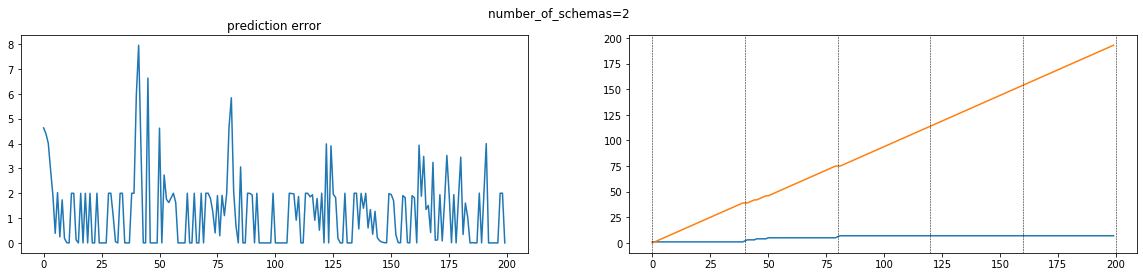

In [63]:
fig,axarr = plt.subplots(1,2,figsize=(20,4))

ax = axarr[0]
fig.suptitle('number_of_schemas=%i '%(nsch))
ax.set_title('prediction error')
ax.plot(peL)

ax = axarr[1]
ax.plot(sch_use.cumsum(1).T)
for bl in range(0,201,40):
  plt.axvline(bl,c='k',ls='--',lw=.5)

### I think current model encourages a single net to dominate because untrained networks have higher PE on shared components between schemas (the first few transitions are the same)

Text(0.5, 1.0, 'SCHEMA B')

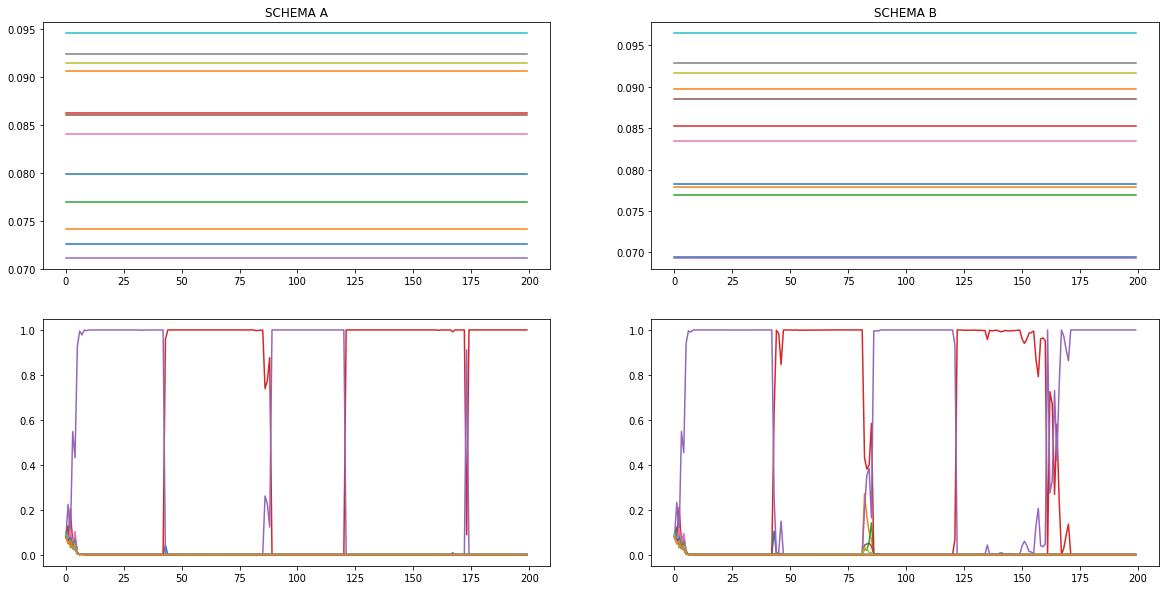

In [64]:
ysm.shape # (net,sch,ep,tstep,smdim)
fig,axarr = plt.subplots(nsch,2,figsize=(20,10))
tstep = 2
for net_idx in range(nsch):
  for sch_idx in range(2):
    ax = axarr[net_idx,sch_idx]
    ysm_net_sch = ysm[net_idx,sch_idx,:,tstep,:]
    ax.plot(ysm_net_sch)

axarr[0,0].set_title('SCHEMA A')
axarr[0,1].set_title('SCHEMA B')


# PE

In [31]:
def mov_avg(A,w=10):
  M = []
  for idx in range(len(A)-w):
    M.append(A[idx:idx+w])
  return np.array(M).mean(1)


## tentative splitting rule
- probability of splitting is proportional to magnitude of positive difference between current PE and local PE average

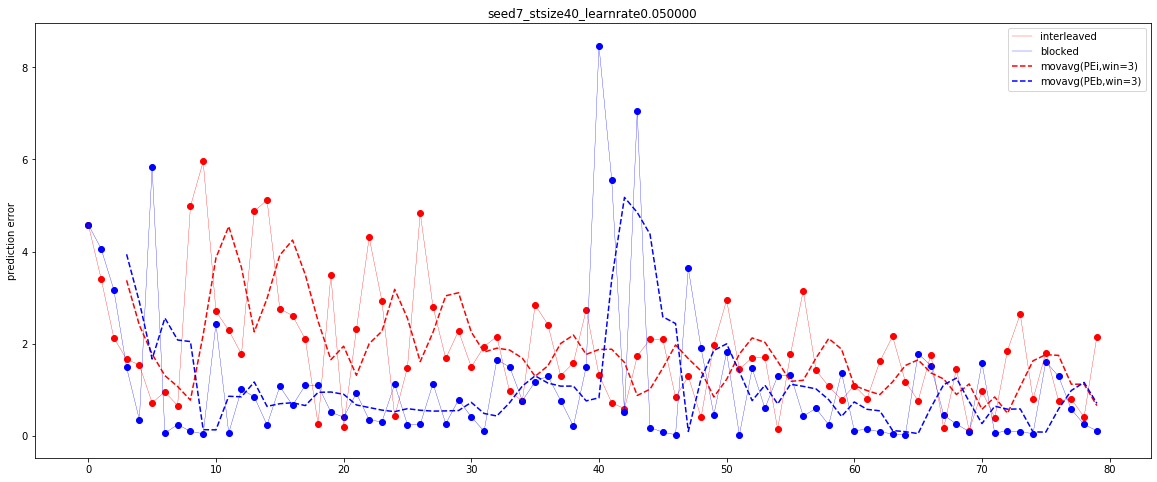

In [32]:
win = 3

plt.figure(figsize=(20,8))
title = 'seed%i_stsize%i_learnrate%f'%(seed,st,learn_rate)
plt.title(title)
plt.plot(PEi,c='r',lw=.3,label='interleaved')
plt.plot(PEb,c='b',lw=.3,label='blocked')
plt.scatter(range(ne),PEi,c='r')
plt.scatter(range(ne),PEb,c='b')
plt.plot(range(win,len(PEi)),mov_avg(PEi,win),c='r',ls='--',label='movavg(PEi,win=%i)'%win)
plt.plot(range(win,len(PEi)),mov_avg(PEb,win),c='b',ls='--',label='movavg(PEb,win=%i)'%win)
plt.legend()
plt.ylabel('prediction error')
plt.savefig('figures/semrep/PE-%s.png'%title)

# loss

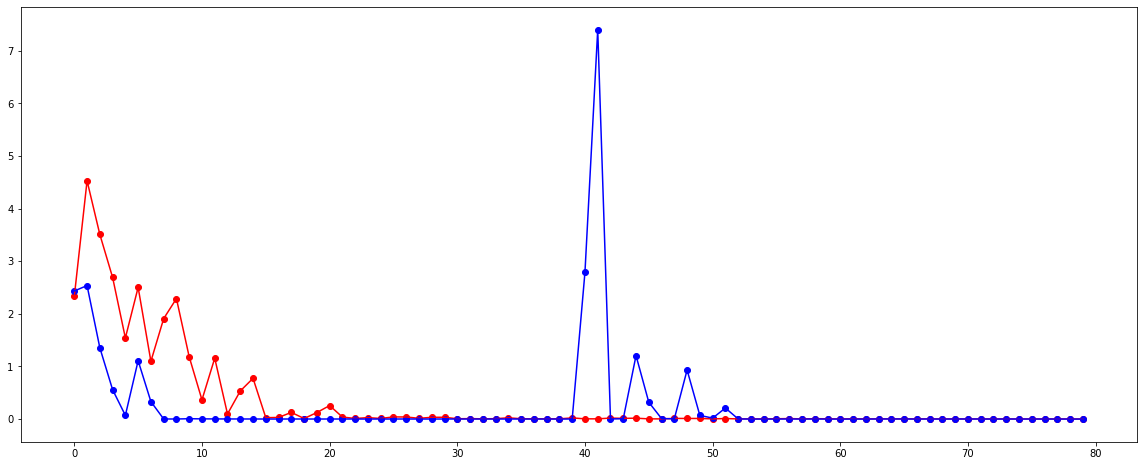

In [7]:
plt.figure(figsize=(20,8))
plt.plot(Li,c='r')
plt.plot(Lb,c='b')
plt.scatter(range(ne),Li,c='r')
plt.scatter(range(ne),Lb,c='b')


# softmax

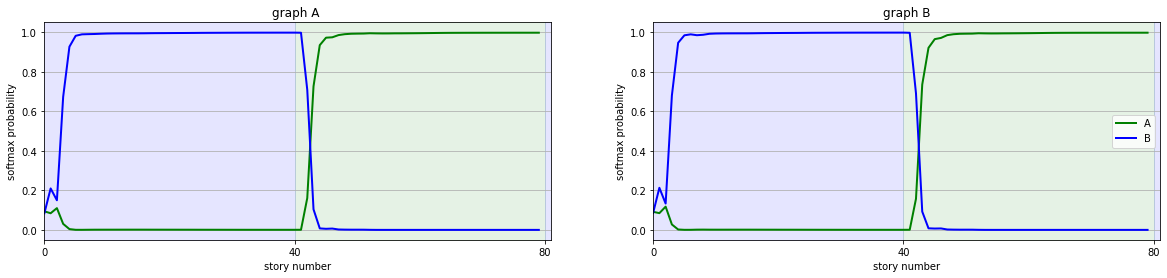

In [8]:
fig,axarr = plt.subplots(1,2,figsize=(20,4))

ysmM = ysmb
# ysmM = ysmi
blocklen=40

tstep = 2
nodes = (3,4)
cL=['g','b']
labL = ['A','B']
tL = ['graph A ','graph B']

for graphid in range(2):
  ax = axarr[graphid]
  ysmM_plt = ysmM[graphid,:,tstep,nodes]

  for idx,M in enumerate(ysmM_plt):
    ax.plot(M,lw=2,c=cL[idx],label=labL[idx])
    ax.set_ylim(-.05,1.05)
    
  if blocklen==40:
    for b in range(4):
      ax.fill_between(range(b*40,(b*40)+41),-0.05,1.05,color=cL[(1+b)%2],alpha=.1)
  else:
    ax.fill_between(range(0,161),-0.05,1.05,color='r',alpha=.1)
  ax.fill_between(range(160,200),-0.05,1.05,color='purple',alpha=.1)
  ax.grid(axis='y')
  ax.set_ylabel('softmax probability')
  ax.set_xlabel('story number')
  ax.set_xticks(range(0,201,40))
  ax.set_title(tL[graphid])
  ax.set_xlim(-.05,81)
plt.legend()
